# Problem Set 4: Wearables

The problems in this problem set pertain to the following paper:

Li, X., Dunn, J., Salins, D., Zhou, G., Zhou, W., Rose, S. M. S. F., ... & Sonecha, R. (2017). [Digital health: tracking physiomes and activity using wearable biosensors reveals useful health-related information.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2001402) PLoS biology, 15(1), e2001402.


Please read this paper before starting this problem set, so you have context.

Interestingly, all of this data has been made publicly available. We will be working with a small subset in order to gain experience working with wearable data. Our goal will be to detect evidence of jetlag in Participant 1 as they travel. [Jetlag](https://en.wikipedia.org/wiki/Jet_lag) is a condition resulting from disrupted circadian rhythm while travelling.

## Part 1: About Time!

Wearable data typically takes the form of a time series. One major factor to consider is how to represent time. We can use a human readable format (ex: **Thursday, March 1, 2018 1:42:59 PM** or **3/1/18 13:42:59**) or a timestamp (ex: **1519940579**). We also need to think about timezone - as Participant 1 travels, their timezone changes, which in turn changes their local time. We often represent timezone by storing a GMT offset. Sometimes it makes sense to work with local time and other times we’ll want to work with GMT. [This](https://www.epochconverter.com) is a useful resource that explains and converts between different representations of time. If you scroll down, it also gives code examples in a variety of languages (including Python and R).

### 1.1

**What is GMT? For the time ​Thursday, March 1, 2018 1:42:59 PM GMT-08:00​, what does GMT-08:00 mean?**

YOUR WRITTEN ANSWER HERE

GMT stands for "Greenwich Mean Time" and is the mean solar time at the Royal Observatory in Greenwich, London, reckoned from midnight. It is considered by many to be synonymous for Coordinated Universal Time or UTC, which is the primary time standard by which the world regulates clocks and time.

GMT-8:00 in this case means that the given time is offset by 28,800 seconds from GMT.

### 1.2

**What is a timestamp, and what does it represent? What date and time is `1519940579`, in human readable format?**

YOUR WRITTEN ANSWER HERE
A timestamp is simply a way to measure time, and is respresents the number of seconds since January 1, 1970. 


Thursday, March 1, 2018 1:42:59 PM GMT-08:00

In [1]:
# YOUR CODE HERE
import time

time.asctime(time.localtime(1519940579))

'Thu Mar  1 13:42:59 2018'

## Part 2: Time-Consuming Analysis

**Participant 1’s sleep data was collected using a Basis Watch and is stored in `sleep_to_03-31-16.csv`. Notice that this file include local start and end times (`local_start_time`, `local_end_time`) as well as timestamps (`start_timestamp`, `end_timestamp`) and GMT start and end times (`start_time_iso`, `end_time_iso`).**

### 2.1

**Let’s figure out how many hours Participant 1 sleeps per day. Make a histogram of the total number of hours slept each day. Use GMT start time to determine what day sleep occurs on and actual_minutes to determine sleep duration. Include a line on the plot showing average sleep per day.**

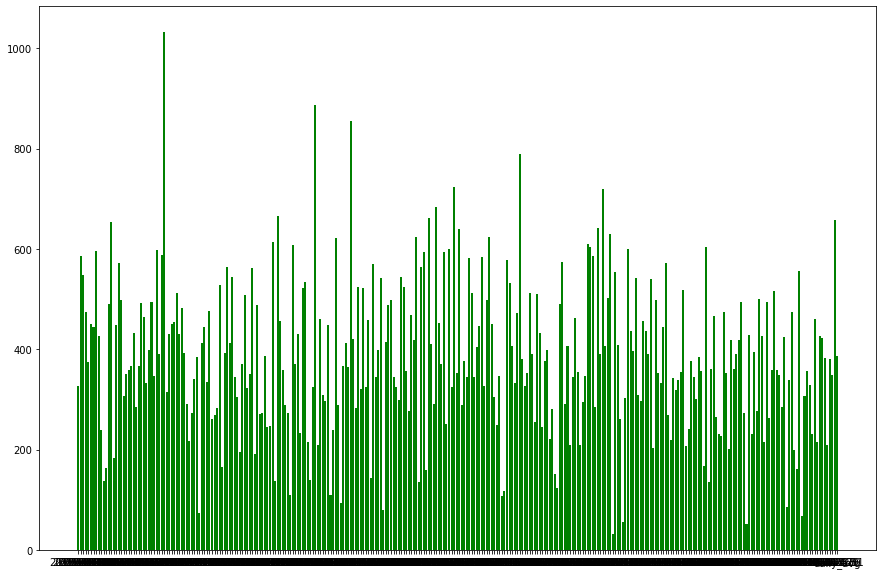

In [96]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date as dt

# Read sleep data from csv
sleep_data = pd.read_csv('sleep_to_03-31-16.csv')

day_sleep = {}
# Add all the actual_minutes into one value, then {date: minutes}
for row_index in sleep_data.index:
    day = dt.fromtimestamp(int(sleep_data['start_timestamp'][row_index]))
    if day not in day_sleep:
        day_sleep[day] = sleep_data['actual_minutes'][row_index]
    else:
        day_sleep[day] += sleep_data['actual_minutes'][row_index]
    

# Convert datetime.date object to string for graphing purposes
times = [str(time) for time in list(day_sleep.keys())]

# Find average sleep per day
avg = 0
for mins in day_sleep.values():
    avg += mins
avg = avg / len(day_sleep)
# Add avg to both the dict and the list for graphing purposes
day_sleep['daily_avg'] = avg
times.append('daily_avg')

plt.figure(figsize=(15, 10))
plt.bar(times, day_sleep.values(), color='g')
plt.show()



### 2.2

**Report basic features of the distribution of daily sleep for Participant 1: mean, median, standard deviation, minimum, and maximum. Comment on whether these values seem reasonable. Do the data look reliable, or do you think the observations are noisy or error-prone?**

In [93]:
# YOUR CODE HERE
import numpy as np

day_sleep.pop('daily_avg', None)
minutes_slept = list(day_sleep.values())

# Basic info on data
def basic_dist(val_list):
    stdev = np.std(val_list)
    mean = np.mean(val_list)
    median = np.median(val_list)
    minim = min(val_list)
    maxim = max(val_list)
    print(f"Standard Deviation: {stdev}\nMean: {mean}\nMedian: {median}\nMinimum: {minim}\nMaximum: {maxim}")

basic_dist(minutes_slept)

Standard Deviation: 152.36828690861222
Mean: 386.40531561461796
Median: 376.0
Minimum: 32
Maximum: 1032


YOUR WRITTEN ANSWER HERE

These data seem noisy and/or error-prone. The standard deviation in particular seems quite high for someone with any degree of regularity in their sleep schedule. Median and mean are consistent with one another but both are a tad low (6.4 hours) which makes me think that our wearable may not be catching all of the time asleep. It's possible that this person slept 25 hours one night and 17 hours another, but not the most likely scenario unless we're looking at a grad student. Also if we are counting the two large gaps as zero values, I think that would be a mistake. The person likely went a period of time without wearing the wearable.

## Part 3: Time Flies

Participant 1’s travel information is in `activities.csv`. This file contains information on a variety of activities, including (somewhat bizarrely) `table_tennis`. Note that start and end times are given in local time but a GMT offset is included.

We would like to extract a list of flights taken by Participant 1. However, as with a lot of wearable data, our labels are imperfect. Some flights are labeled `airplane` in the `Activity` column and others are labelled `transport`. However, `transport` is also used for car rides, train rides, etc. We will define a flight as an activity that is either (labeled `airplane`) OR (labeled `transport` AND has an average speed over 100 miles/hour). You can calculate speed from `Duration` (given in seconds) and `Distance` (given in miles).

### 3.1

**How many flights did Participant 1 take? Plot a histogram of the duration (in hours) of these flights. Is there anything unexpected about the distribution of durations? Give an explanation for what could give rise to these observations, and propose a way to post-process them (for purposes of this assignment, we'll be leaving these data as-is).**

{datetime.date(2014, 3, 23): 14721, datetime.date(2014, 3, 24): 14057, datetime.date(2014, 3, 25): 14156, datetime.date(2014, 3, 28): 40406, datetime.date(2014, 4, 1): 14451, datetime.date(2014, 4, 3): 16009, datetime.date(2014, 4, 6): 8300, datetime.date(2014, 4, 8): 6824, datetime.date(2014, 4, 14): 7178, datetime.date(2014, 4, 16): 5674, datetime.date(2014, 4, 17): 10186, datetime.date(2014, 4, 28): 5853, datetime.date(2014, 5, 1): 16797, datetime.date(2014, 5, 2): 3932, datetime.date(2014, 5, 5): 3878, datetime.date(2014, 5, 6): 15990, datetime.date(2014, 5, 7): 4450, datetime.date(2014, 5, 8): 18006, datetime.date(2014, 5, 9): 46190, datetime.date(2014, 5, 11): 50207, datetime.date(2014, 5, 14): 8426, datetime.date(2014, 5, 15): 21524, datetime.date(2014, 5, 18): 18608, datetime.date(2014, 5, 19): 24184, datetime.date(2014, 5, 27): 7026, datetime.date(2014, 5, 29): 9214, datetime.date(2014, 6, 3): 20084, datetime.date(2014, 6, 8): 25933, datetime.date(2014, 6, 14): 6759, datetime.

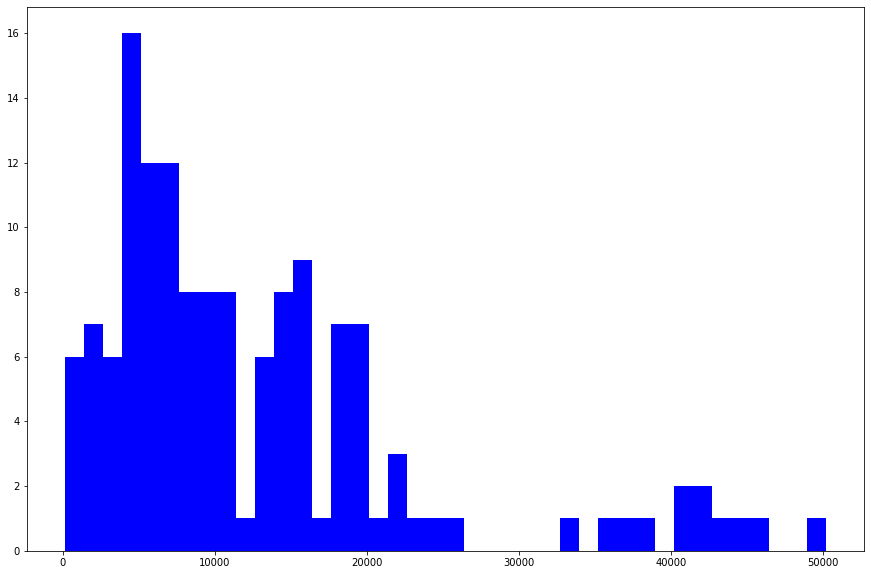

In [116]:
# YOUR CODE HERE
from datetime import date
# Add Speed to dataframe
activities = pd.read_csv('activities.csv')
activities['Speed'] = activities['Distance'] / (activities['Duration']/60/60)

flt_dur = {}
# Log all of the flight time
for row in activities.index:
    if activities['Activity'][row] == 'airplane' or (activities['Activity'][row] == 'transport' and activities['Speed'][row]>100):
        isoformat, _ = activities['Start'][row].split('T', 1)
        # i.e. {datetime.date(2014, 3, 23): minutes}
        flt_dur[date.fromisoformat(isoformat)] = activities['Duration'][row]
        
# Statistical info about flight duration
air_time = list(flt_dur.values())
basic_dist(air_time)
print(f"Number of flights: {len(flt_dur)}")

plt.figure(figsize=(15, 10))
plt.hist(air_time, bins= 40, color='b')
plt.show()

YOUR WRITTEN ANSWER HERE

We have a few outliers which pulls the mean significantly away from the median and makes the standard deviation enormous. This is likely from the tran-oceanic flights vs. the intracontinental flights. In addition, the csv file separates fligts that occur during 12am into two instances, which shifts our curve to the left. In our processing we could account for this by combining neighboring flights that start/stop right at midnight.

### 3.2

**Now we know when Participant 1 travelled and when they slept. Let’s put them together. We want to compare Participant 1’s sleep after travelling to their usual sleep. To do this, we’ll want to use GMT for both our flight and sleep times. Using the flight dates from question 3.1, generate a set of dates within 3 days of flight. That is, if they travelled on 3/23/14, then you should include 3/23/14, 3/24/14, and 3/25/14 as "after-flight" dates**. 

**Re-make the histogram of sleep duration from (2.1), stratifying by whether the date is an "after-flight" day. Then use a t-test to compare sleep "after-flight" to sleep not "after-flight" and report your results.**

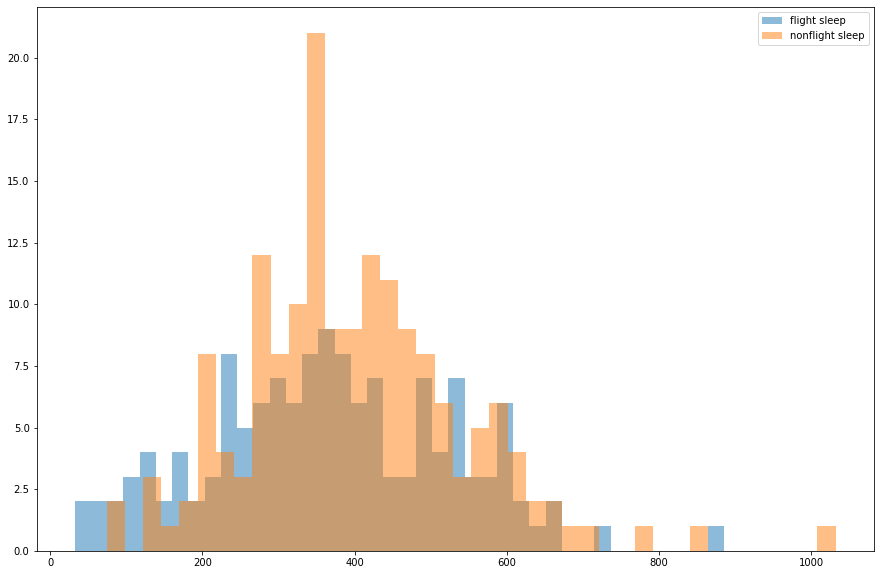

t-test stat: -1.8234651500388228
p-value: 0.06922793030802941


In [144]:
# YOUR CODE HERE
import datetime
from matplotlib import pyplot
import scipy.stats as stats

# Generate set of dates within 3 days of flight.
flight_dates = list(flt_dur.keys())

flight_effect = set()
for date in flight_dates:
    for i in range(3):
        flight_effect.add(date + datetime.timedelta(days=i))

# All sleeping days
dates = [time for time in list(day_sleep.keys())]
# Separate sleep days into flight sleep and non-flight sleep.
flight_sleeps = set()
nonflight_sleeps = set()
for date in dates:
    if date in flight_effect:
        flight_sleeps.add(date)
    else:
        nonflight_sleeps.add(date)

flt_snooze = [v for k,v in day_sleep.items() if k in flight_sleeps]
norm_snooze = [v for k,v in day_sleep.items() if k in nonflight_sleeps]
# print(f"flightsleep: {flt_snooze}\n\nnonflightsleep: {norm_snooze}")

# Plot histogram of both cases
pyplot.figure(figsize=(15, 10))
pyplot.hist(flt_snooze, bins= 40, alpha=0.5, label='flight sleep')
pyplot.hist(norm_snooze, bins=40, alpha=0.5, label='nonflight sleep')
pyplot.legend(loc='upper right')
pyplot.show()

# T-test of both sets
flt = np.array(flt_snooze)
norm = np.array(norm_snooze)

eq_var = False
if np.var(flt) > np.var(norm):
    if np.var(flt) / np.var(norm) < 4:
        eq_var = True
else:
    if np.var(norm) / np.var(flt) < 4:
        eq_var = True

if eq_var:
    t_test_stat, p_val = stats.ttest_ind(a=flt, b=norm, equal_var=True)
    print(f"t-test stat: {t_test_stat}\np-value: {p_val}")
else:
    print("Error: Cannot assume equal variance!")

### 3.3

**What can we conclude about airplane flights and sleep for Participant 1? Is there an association between the two, and if so, how large is the effect?**

In [ ]:
# YOUR CODE HERE

YOUR WRITTEN ANSWER HERE
Based on the p-value from the t-test, it doesn't seem like we can reject the null hypothesis that these two datasets are significantly different.